<a href="https://colab.research.google.com/github/AyushMaria/Expected-xG-Goals-Football/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install import-ipynb
!pip install eli5
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 5.2 MB/s 
     |████████████████████████████████| 133 kB 54.4 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=c31d239a95649d8ff8db509e17ac6991d615c2056bfe1bb231bf5dba44bc2aeb
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which 

In [2]:
# importing the tools to call google drive
from google.colab import drive


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import uniform

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, log_loss
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

import eli5
import shap
import import_ipynb

In [10]:
# mount our directory
mount='/content/gdrive'
drive.mount(mount, force_remount=True)

Mounted at /content/gdrive


In [11]:
# Switch to the directory on the VM for our purposes
drive_root=mount + '/My Drive/Colab Notebooks/Thesis'
%cd $drive_root
%pwd

/content/gdrive/My Drive/Colab Notebooks/Thesis


'/content/gdrive/My Drive/Colab Notebooks/Thesis'

In [12]:
import Pitch_Plot
import data
from data import obtain_seasons,fetch_url,Game
from Pitch_Plot import pitchplot

importing Jupyter notebook from Pitch_Plot.ipynb
importing Jupyter notebook from data.ipynb


In [13]:
df = pd.read_pickle('./final_data.pkl')

In [14]:
df.columns

Index(['shot id', 'play pattern', 'x location shot', 'y location shot',
       'duration', 'outcome', 'technique used', 'first time', 'x gk location',
       'y gk location', 'body part', 'type of shot',
       'Number of opponents in 5 yards', 'Players between goal', 'player name',
       'Team Name', 'official xg', 'Pass id', 'Pass Type', 'game_id',
       'season_id', 'distance_from_goalpost_a', 'distance_from_goalpost_b',
       'shot_angle'],
      dtype='object')

In [15]:
df['shot distance'] = round(np.sqrt((df['x location shot']-120)**2+(df['y location shot']-40)**2),1)

In [16]:
df['gk distance'] = round(np.sqrt((df['x gk location']-120)**2+(df['y gk location']-40)**2),1)
df

,shot id,play pattern,x location shot,y location shot,duration,outcome,technique used,first time,x gk location,y gk location,...,official xg,Pass id,Pass Type,game_id,season_id,distance_from_goalpost_a,distance_from_goalpost_b,shot_angle,shot distance,gk distance
0,56deeffa-ff55-429e-91df-41f237a3ebac,Regular Play,103.7,46.3,0.909600,Saved,Normal,True,116.0,43.0,...,0.174474,448cb3aa-ee0b-4829-a7d4-bdef6dfda5bd,Ground Pass,68311,2019,19.281597,16.461470,24.3,17.5,5.0
1,00d9c066-1078-4e1c-8c7f-2ca299e3a5f0,From Free Kick,107.4,37.4,1.033500,Goal,Normal,False,118.3,39.9,...,0.028797,f5d55ee4-2db3-4604-b9fa-8bd0645fdc4b,High Pass,68311,2019,12.677539,14.223924,34.0,12.9,1.7
2,48706448-928f-4721-96ec-2b813f448937,Regular Play,108.5,48.1,1.391602,Off T,Normal,False,118.9,42.8,...,0.027564,13eaef4e-1393-4b99-b94d-d60c35070713,High Pass,68311,2019,16.693112,12.209013,26.8,14.1,3.0
3,718f8a06-078c-489e-9423-63d414be5e43,From Throw In,106.0,43.7,1.154700,Saved,Normal,False,118.9,42.1,...,0.025206,be417f5e-798b-4dd0-a651-4b7a9d2e3564,High Pass,68311,2019,15.977797,14.003214,30.0,14.5,2.4
4,e1b29724-4861-4d12-9a51-ac6635e97438,From Corner,112.4,42.9,0.907511,Off T,Normal,False,119.3,40.7,...,0.065884,ef4852cb-22f5-4afe-8355-5ec0752f9adb,High Pass,68311,2019,10.264989,7.679193,50.5,8.1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23512,4468faac-ae6a-4637-928b-fc7dd448411b,From Free Kick,91.1,47.1,1.622413,Post,Normal,False,118.4,40.8,...,0.049559,No Pass,None,68353,2004/2005,30.958359,29.065787,14.9,29.8,1.8
23513,5f613006-c00e-4581-882c-a7a81978ebf0,From Throw In,103.7,33.6,1.070861,Off T,Half Volley,False,119.5,39.8,...,0.057103,No Pass,None,68353,2004/2005,16.475740,19.335201,24.2,17.5,0.5
23514,717c9351-6eff-4f71-969a-e25bab5bfcb6,From Throw In,107.9,37.0,0.701300,Saved,Volley,True,119.2,39.6,...,0.113389,dbaca88f-32d3-4abe-a37d-4fceb67a4302,Low Pass,68353,2004/2005,12.141252,13.978913,34.8,12.5,0.9
23515,0c914938-af14-479e-8043-8e4bfdfd474d,From Throw In,117.8,43.9,1.256200,Post,Normal,False,118.9,43.3,...,0.415576,No Pass,None,68353,2004/2005,8.200610,2.202272,77.0,4.5,3.5


In [17]:
df.set_index("shot id")

,play pattern,x location shot,y location shot,duration,outcome,technique used,first time,x gk location,y gk location,body part,...,official xg,Pass id,Pass Type,game_id,season_id,distance_from_goalpost_a,distance_from_goalpost_b,shot_angle,shot distance,gk distance
shot id,,,,,,,,,,,,,,,,,,,,,
56deeffa-ff55-429e-91df-41f237a3ebac,Regular Play,103.7,46.3,0.909600,Saved,Normal,True,116.0,43.0,Right Foot,...,0.174474,448cb3aa-ee0b-4829-a7d4-bdef6dfda5bd,Ground Pass,68311,2019,19.281597,16.461470,24.3,17.5,5.0
00d9c066-1078-4e1c-8c7f-2ca299e3a5f0,From Free Kick,107.4,37.4,1.033500,Goal,Normal,False,118.3,39.9,Head,...,0.028797,f5d55ee4-2db3-4604-b9fa-8bd0645fdc4b,High Pass,68311,2019,12.677539,14.223924,34.0,12.9,1.7
48706448-928f-4721-96ec-2b813f448937,Regular Play,108.5,48.1,1.391602,Off T,Normal,False,118.9,42.8,Head,...,0.027564,13eaef4e-1393-4b99-b94d-d60c35070713,High Pass,68311,2019,16.693112,12.209013,26.8,14.1,3.0
718f8a06-078c-489e-9423-63d414be5e43,From Throw In,106.0,43.7,1.154700,Saved,Normal,False,118.9,42.1,Head,...,0.025206,be417f5e-798b-4dd0-a651-4b7a9d2e3564,High Pass,68311,2019,15.977797,14.003214,30.0,14.5,2.4
e1b29724-4861-4d12-9a51-ac6635e97438,From Corner,112.4,42.9,0.907511,Off T,Normal,False,119.3,40.7,Head,...,0.065884,ef4852cb-22f5-4afe-8355-5ec0752f9adb,High Pass,68311,2019,10.264989,7.679193,50.5,8.1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4468faac-ae6a-4637-928b-fc7dd448411b,From Free Kick,91.1,47.1,1.622413,Post,Normal,False,118.4,40.8,Left Foot,...,0.049559,No Pass,None,68353,2004/2005,30.958359,29.065787,14.9,29.8,1.8
5f613006-c00e-4581-882c-a7a81978ebf0,From Throw In,103.7,33.6,1.070861,Off T,Half Volley,False,119.5,39.8,Left Foot,...,0.057103,No Pass,None,68353,2004/2005,16.475740,19.335201,24.2,17.5,0.5
717c9351-6eff-4f71-969a-e25bab5bfcb6,From Throw In,107.9,37.0,0.701300,Saved,Volley,True,119.2,39.6,Right Foot,...,0.113389,dbaca88f-32d3-4abe-a37d-4fceb67a4302,Low Pass,68353,2004/2005,12.141252,13.978913,34.8,12.5,0.9


In [18]:
Goal_label = []
binary_outcome = []
for outcome in df['outcome'].values:
    if outcome == 'Goal':
        Goal_label.append('Goal')
        binary_outcome.append(1)
    else:
        Goal_label.append('Not Goal')
        binary_outcome.append(0)
df['Goal_label'] = Goal_label
df['binary_outcome'] = binary_outcome

In [19]:
df = df.set_index("shot id")
df

,play pattern,x location shot,y location shot,duration,outcome,technique used,first time,x gk location,y gk location,body part,...,Pass Type,game_id,season_id,distance_from_goalpost_a,distance_from_goalpost_b,shot_angle,shot distance,gk distance,Goal_label,binary_outcome
shot id,,,,,,,,,,,,,,,,,,,,,
56deeffa-ff55-429e-91df-41f237a3ebac,Regular Play,103.7,46.3,0.909600,Saved,Normal,True,116.0,43.0,Right Foot,...,Ground Pass,68311,2019,19.281597,16.461470,24.3,17.5,5.0,Not Goal,0
00d9c066-1078-4e1c-8c7f-2ca299e3a5f0,From Free Kick,107.4,37.4,1.033500,Goal,Normal,False,118.3,39.9,Head,...,High Pass,68311,2019,12.677539,14.223924,34.0,12.9,1.7,Goal,1
48706448-928f-4721-96ec-2b813f448937,Regular Play,108.5,48.1,1.391602,Off T,Normal,False,118.9,42.8,Head,...,High Pass,68311,2019,16.693112,12.209013,26.8,14.1,3.0,Not Goal,0
718f8a06-078c-489e-9423-63d414be5e43,From Throw In,106.0,43.7,1.154700,Saved,Normal,False,118.9,42.1,Head,...,High Pass,68311,2019,15.977797,14.003214,30.0,14.5,2.4,Not Goal,0
e1b29724-4861-4d12-9a51-ac6635e97438,From Corner,112.4,42.9,0.907511,Off T,Normal,False,119.3,40.7,Head,...,High Pass,68311,2019,10.264989,7.679193,50.5,8.1,1.0,Not Goal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4468faac-ae6a-4637-928b-fc7dd448411b,From Free Kick,91.1,47.1,1.622413,Post,Normal,False,118.4,40.8,Left Foot,...,None,68353,2004/2005,30.958359,29.065787,14.9,29.8,1.8,Not Goal,0
5f613006-c00e-4581-882c-a7a81978ebf0,From Throw In,103.7,33.6,1.070861,Off T,Half Volley,False,119.5,39.8,Left Foot,...,None,68353,2004/2005,16.475740,19.335201,24.2,17.5,0.5,Not Goal,0
717c9351-6eff-4f71-969a-e25bab5bfcb6,From Throw In,107.9,37.0,0.701300,Saved,Volley,True,119.2,39.6,Right Foot,...,Low Pass,68353,2004/2005,12.141252,13.978913,34.8,12.5,0.9,Not Goal,0


# Creating training, testing and validation data


In [20]:
features = df.drop(["outcome"], axis=1)
targets = df["outcome"]

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(features.loc[X_train.index], targets[X_train.index], test_size=0.2)

train = pd.merge(X_train, y_train, left_index=True, right_index=True)
validate = pd.merge(X_valid, y_valid, left_index=True, right_index=True)
test = pd.merge(X_test, y_test, left_index=True, right_index=True)

In [21]:
train.columns

Index(['play pattern', 'x location shot', 'y location shot', 'duration',
       'technique used', 'first time', 'x gk location', 'y gk location',
       'body part', 'type of shot', 'Number of opponents in 5 yards',
       'Players between goal', 'player name', 'Team Name', 'official xg',
       'Pass id', 'Pass Type', 'game_id', 'season_id',
       'distance_from_goalpost_a', 'distance_from_goalpost_b', 'shot_angle',
       'shot distance', 'gk distance', 'Goal_label', 'binary_outcome',
       'outcome'],
      dtype='object')

In [22]:
train

,play pattern,x location shot,y location shot,duration,technique used,first time,x gk location,y gk location,body part,type of shot,...,game_id,season_id,distance_from_goalpost_a,distance_from_goalpost_b,shot_angle,shot distance,gk distance,Goal_label,binary_outcome,outcome
shot id,,,,,,,,,,,,,,,,,,,,,
1df89f12-e46c-45b6-bee9-2d9eb46a6b29,From Throw In,100.6,54.8,0.602587,Normal,True,118.7,43.0,Right Foot,Open Play,...,3764235,2020/2021,27.014811,22.203603,15.0,24.4,3.3,Not Goal,0,Blocked
34fec8e9-8177-49b9-a987-968496a4e5c8,From Goal Kick,111.4,48.0,0.756098,Half Volley,False,118.7,43.1,Right Foot,Open Play,...,266846,2014/2015,14.763468,9.484725,29.4,11.7,3.4,Goal,1,Goal
fde780e3-0b21-4cad-9c10-a77a2edb0ff0,Regular Play,108.3,37.9,0.971700,Normal,False,119.4,39.0,Head,Open Play,...,70283,2013/2014,11.853270,13.194696,36.8,11.9,1.2,Not Goal,0,Off T
d19df91c-06af-4e33-adfe-944a0267c574,From Throw In,79.7,50.1,1.239718,Normal,False,116.1,40.2,Right Foot,Open Play,...,70298,2013/2014,42.695433,40.759048,10.7,41.5,3.9,Not Goal,0,Off T
86c7c837-2dcd-494e-abee-d4640a13af7b,From Throw In,97.0,55.0,1.037941,Normal,False,116.0,42.0,Right Foot,Open Play,...,19736,2018/2019,29.832868,25.495098,14.0,27.5,4.5,Not Goal,0,Saved
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54cf6e9d-8331-4671-80ef-affc2e380572,From Corner,114.5,44.2,0.628173,Normal,False,119.2,40.6,Head,Open Play,...,19818,2018/2019,9.873702,5.503635,54.1,6.9,1.0,Not Goal,0,Saved
5f5e5f0b-1bc8-49c4-8d6a-7e0152b6b492,From Corner,114.1,44.0,0.056400,Normal,False,119.2,41.6,Head,Open Play,...,266838,2014/2015,9.940322,5.900000,53.6,7.1,1.8,Not Goal,0,Blocked
43d67ec4-6e3d-4da0-96c0-d428f67b9d7d,Regular Play,108.2,44.3,0.945700,Half Volley,False,112.3,43.3,Right Foot,Open Play,...,69255,2009/2010,14.426711,11.803813,33.7,12.6,8.4,Goal,1,Goal


In [23]:
df_regular_play = train[train['play pattern']=='Regular Play']
df_regular_play

,play pattern,x location shot,y location shot,duration,technique used,first time,x gk location,y gk location,body part,type of shot,...,game_id,season_id,distance_from_goalpost_a,distance_from_goalpost_b,shot_angle,shot distance,gk distance,Goal_label,binary_outcome,outcome
shot id,,,,,,,,,,,,,,,,,,,,,
fde780e3-0b21-4cad-9c10-a77a2edb0ff0,Regular Play,108.3,37.9,0.971700,Normal,False,119.4,39.0,Head,Open Play,...,70283,2013/2014,11.853270,13.194696,36.8,11.9,1.2,Not Goal,0,Off T
ce0a9744-635d-473d-a8e5-c12533382651,Regular Play,110.5,46.9,0.575186,Normal,True,118.0,42.7,Right Foot,Open Play,...,303682,2019/2020,14.458907,9.932774,32.0,11.7,3.4,Not Goal,0,Saved
54026ba9-9f8a-4696-8284-f7810c96e124,Regular Play,111.5,32.7,0.935902,Normal,False,119.1,36.9,Right Foot,Open Play,...,2275026,2019/2020,9.118114,14.140014,31.8,11.2,3.2,Goal,1,Goal
37c5b747-0f25-4b31-bf22-27211919e9e9,Regular Play,110.3,27.0,0.889900,Lob,True,116.8,33.5,Left Foot,Open Play,...,70308,2012/2013,13.232158,19.572685,17.4,16.2,7.2,Not Goal,0,Saved
67e88009-f425-4ef0-aa05-e719b2576d1c,Regular Play,112.9,35.9,0.031706,Normal,False,118.6,39.9,Head,Open Play,...,2275028,2019/2020,7.100704,10.771258,48.0,8.2,1.4,Not Goal,0,Blocked
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cdff2178-6bcf-45c9-acae-a7242bf4c2d1,Regular Play,95.6,45.8,0.107900,Normal,True,119.3,41.1,Right Foot,Open Play,...,266467,2015/2016,26.294486,24.466303,17.7,25.1,1.3,Not Goal,0,Blocked
43444c66-610c-40ca-8ec7-ffca442fcc55,Regular Play,113.1,47.8,0.331074,Normal,False,116.9,42.7,Right Foot,Open Play,...,3773585,2020/2021,13.669309,7.877182,30.8,10.4,4.1,Not Goal,0,Saved
43d67ec4-6e3d-4da0-96c0-d428f67b9d7d,Regular Play,108.2,44.3,0.945700,Half Volley,False,112.3,43.3,Right Foot,Open Play,...,69255,2009/2010,14.426711,11.803813,33.7,12.6,8.4,Goal,1,Goal


Let's check how distance has an affect on expected goals followed by angle.

In [24]:
def goals(fig,locations,color,label):
    loc_x=[]
    loc_y=[]
    for loc in locations:
        loc_x.append(loc[0])
        loc_y.append(loc[1])        
    plt.scatter(loc_x,loc_y,c=color,alpha=0.6,label=label,edgecolor='black',linewidth=0.5)
    plt.axis('off')
    return fig

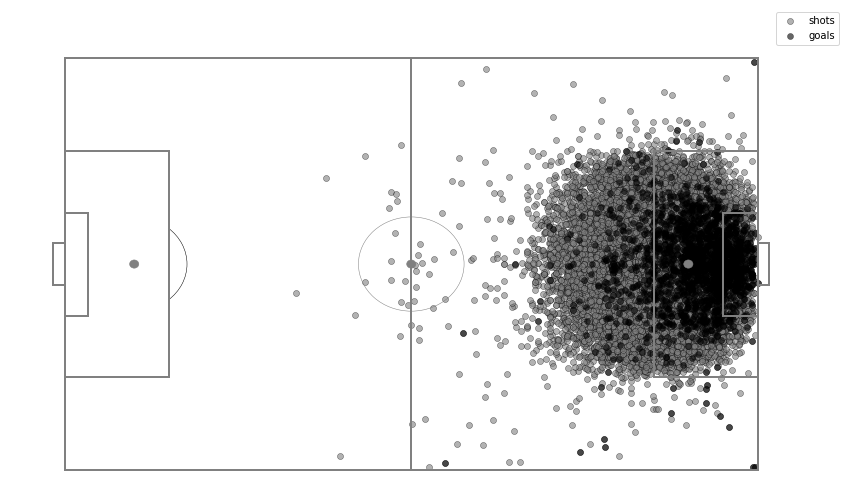

In [25]:
pitch = pitchplot()
pitch = goals(plt,train[['x location shot','y location shot']].values,'grey','shots')
pitch = goals(plt,train[train['Goal_label']=='Goal'][['x location shot','y location shot']].values,'black','goals')
plt.legend(loc='upper right')
plt.show()

In [26]:
def allgoals(fig,df):    
    sns.histplot(data=df_regular_play, x="x location shot", y="y location shot",cbar=True,cbar_kws=dict(shrink=.25), pmax=0.85, palette='Reds')
    #px.density_heatmap(df_regular_play, x="x location shot",y ="y location shot")
    plt.axis('off')
    return plt

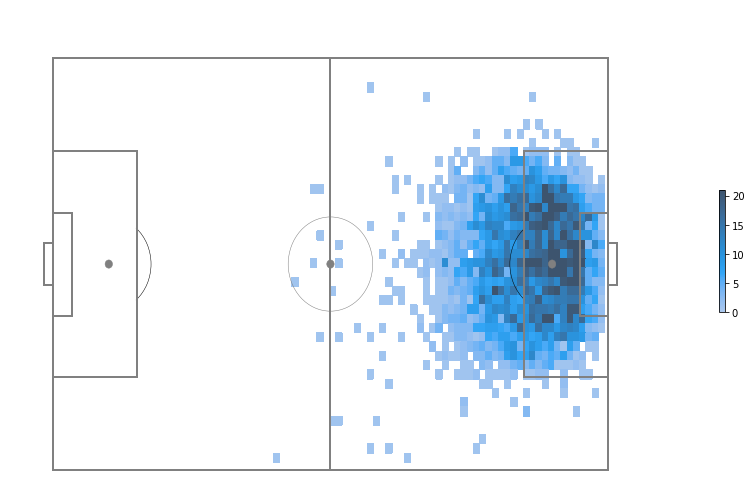

In [27]:
df_goals = df_regular_play[df_regular_play['Goal_label']=='Goal']
pitch = pitchplot()
pitch = allgoals(pitch,df_goals)
plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


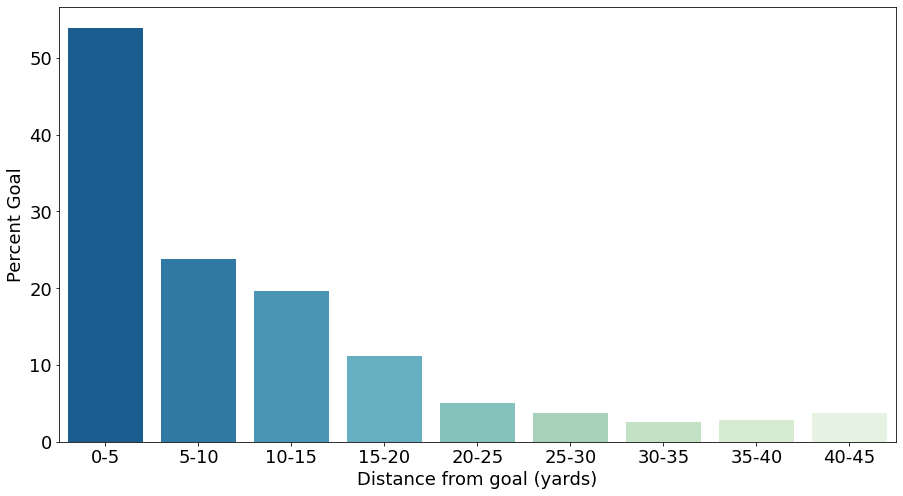

In [132]:
distance = train[["shot distance", "binary_outcome"]]
distance["shot distance"] = distance["shot distance"].floordiv(5)
distance["binary_outcome"] = pd.to_numeric(distance["binary_outcome"]) * 100
outcome = distance.groupby("shot distance").mean().reset_index().iloc[0:9]

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.barplot(data=outcome,x="shot distance", y="binary_outcome", ax=ax, palette='GnBu_r')
plt.xticks(np.arange(9), ("0-5", "5-10", "10-15", "15-20", "20-25", "25-30", "30-35", "35-40", "40-45"))
plt.xlabel("Distance from goal (yards)", size=18)
plt.ylabel("Percent Goal", size=18)
plt.tick_params(labelsize=18)

Clearly the number of goals are reducing as the distance is increasing. Most of the goals are scored from within the box.

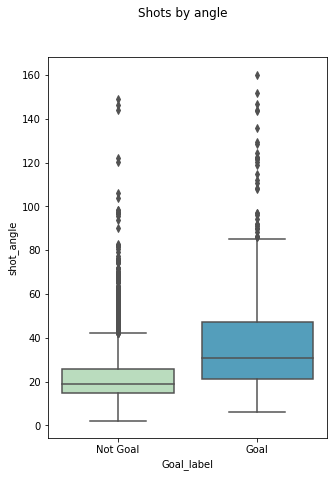

In [75]:
fig,ax=plt.subplots(1,1,figsize=(5,7))
fig.suptitle('Shots by angle')
sns.boxplot(x='Goal_label',y='shot_angle',data=df_regular_play, palette = 'GnBu')

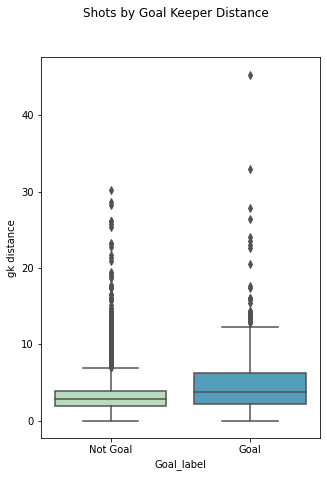

In [76]:
fig,ax=plt.subplots(1,1,figsize=(5,7))
fig.suptitle('Shots by Goal Keeper Distance')
sns.boxplot(x='Goal_label',y='gk distance',data=df_regular_play, palette = 'GnBu')

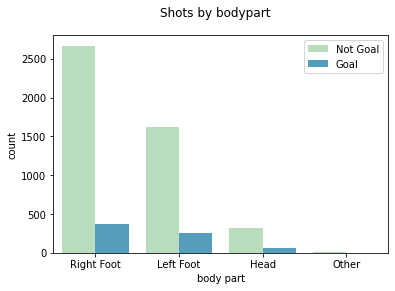

In [77]:
fig,ax=plt.subplots(1,1)
fig.suptitle('Shots by bodypart')
sns.countplot(x='body part',order=['Right Foot','Left Foot','Head','Other'],hue='Goal_label',data=df_regular_play, palette = 'GnBu')
plt.legend(loc='upper right')

In [78]:
footed_shots = (df_regular_play['body part']=='Right Foot') | (df_regular_play['body part']=='Left Foot')
shots_from_foot = df_regular_play[footed_shots].shape[0]
goals_from_foot = sum(df_regular_play[footed_shots]['binary_outcome'])

headed_shots = (df_regular_play['body part']=='Head')
shots_from_head = df_regular_play[headed_shots].shape[0]
goals_from_head = sum(df_regular_play[headed_shots]['binary_outcome'])

feetperc = goals_from_foot/shots_from_foot
headperc = goals_from_head/shots_from_head

print(feetperc*100,'%')
print(headperc*100,'%')

12.700997353958885 %
17.195767195767196 %


This shows that headed goals are more effective than footed goals. There is a skewness of that we need to consider first.

Text(0.5, 1.0, 'Headed Shots')

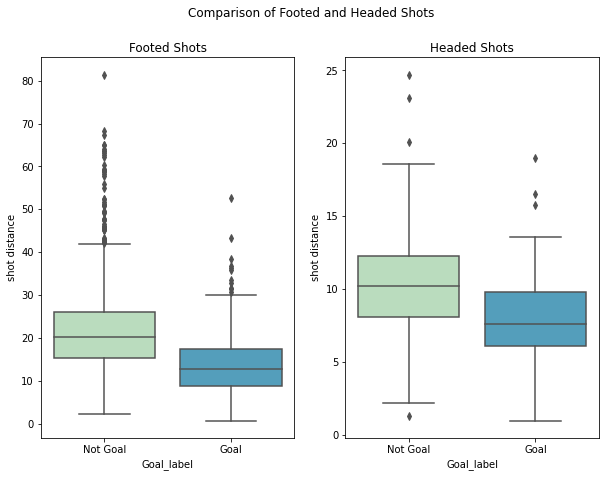

In [79]:
fig,axis = plt.subplots(1,2, figsize=(10,7))
fig.suptitle('Comparison of Footed and Headed Shots')
sns.boxplot(x='Goal_label',y='shot distance',data=df_regular_play[footed_shots],ax=axis[0],palette='GnBu')
sns.boxplot(x='Goal_label',y='shot distance',data=df_regular_play[headed_shots],ax=axis[1],palette='GnBu')
axis[0].set_title('Footed Shots')
axis[1].set_title('Headed Shots')

This figure shows that almost all headed shots are taken from a distance of 18 yards.

In [80]:
eighteen_yardf = df_regular_play[footed_shots]['shot distance']<18
footed18_shots = df_regular_play[footed_shots][eighteen_yardf].shape[0]
footed18_goals = sum(df_regular_play[footed_shots][eighteen_yardf]['binary_outcome'])

eighteen_yardh = df_regular_play[headed_shots]['shot distance']<18
headed18_shots = df_regular_play[headed_shots][eighteen_yardh].shape[0]
headed18_goals = sum(df_regular_play[headed_shots][eighteen_yardh]['binary_outcome'])

feetperc18 = footed18_goals/footed18_shots
headperc18 = headed18_goals/headed18_shots

print(feetperc18*100,'%')
print(headperc18*100,'%')

22.72083136513935 %
17.158176943699733 %


After checking the goals from the 18 yard distance, it is clear that the footed goals are more effective. 

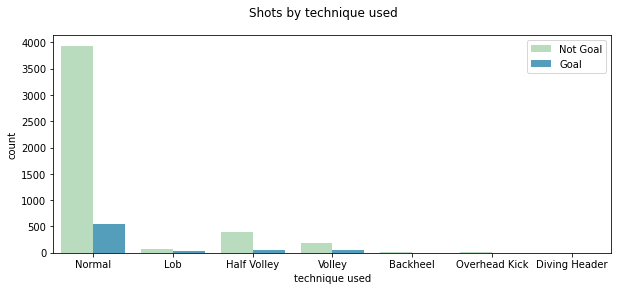

In [72]:
fig,ax=plt.subplots(1,1, figsize=(10,4))
fig.suptitle('Shots by technique used')
sns.countplot(x='technique used',hue='Goal_label',data=df_regular_play, palette = 'GnBu')
plt.legend(loc='upper right')

In [ ]:
normal_shots = (df_regular_play['technique used']=='Normal') 
volley_shots = (df_regular_play['technique used']=='Volley')
halfvolley_shots = (df_regular_play['technique used']=='Half Volley')
other_shots = (df_regular_play['technique used']=='Lob technique used') | (df_regular_play['technique used']!='Backheel') | (df_regular_play['technique used']!='Diving Header') | (df_regular_play['technique used']!='Overhead Kick')

In [ ]:
shots_normal = df_regular_play[normal_shots].shape[0]
goals_normal = sum(df_regular_play[normal_shots]['binary_outcome'])
perc_normal = goals_normal/shots_normal*100

shots_volley = df_regular_play[volley_shots].shape[0]
goals_volley = sum(df_regular_play[volley_shots]['binary_outcome'])
perc_volley = goals_volley/shots_volley*100

shots_halfvolley = df_regular_play[halfvolley_shots].shape[0]
goals_halfvolley = sum(df_regular_play[halfvolley_shots]['binary_outcome'])
perc_halfvolley = goals_halfvolley/shots_halfvolley*100

shots_other = df_regular_play[other_shots].shape[0]
goals_other = sum(df_regular_play[other_shots]['binary_outcome'])
perc_other = goals_other/shots_other*100

print(perc_normal)
print(perc_volley)
print(perc_halfvolley)
print(perc_other)

12.05895489057615
21.940928270042196
11.03448275862069
12.880650652543975


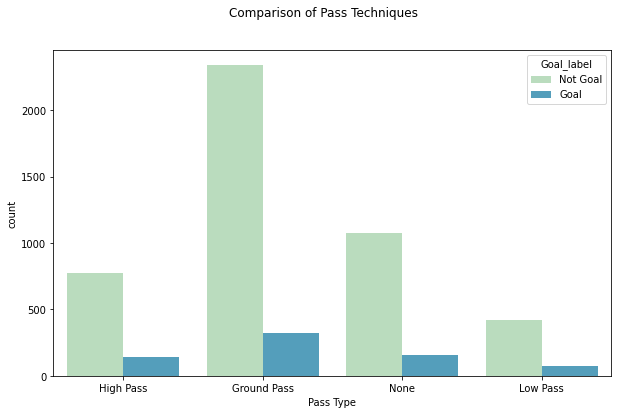

In [70]:
fig,axis = plt.subplots(1,1, figsize=(10,6))
fig.suptitle('Comparison of Pass Techniques')
sns.countplot(x='Pass Type',data=df_regular_play,hue ='Goal_label',ax=axis,palette='GnBu')

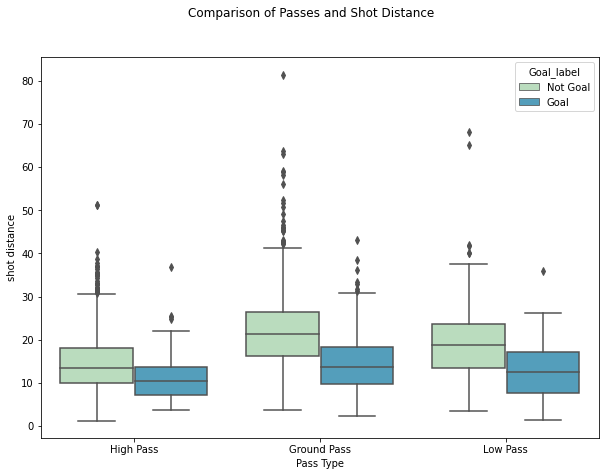

In [69]:
fig,axis = plt.subplots(1,1, figsize=(10,7))
fig.suptitle('Comparison of Passes and Shot Distance')
df_none = df_regular_play[df_regular_play['Pass Type']!='None']
sns.boxplot(x='Pass Type',y='shot distance',data=df_none,hue='Goal_label',ax=axis,palette='GnBu')

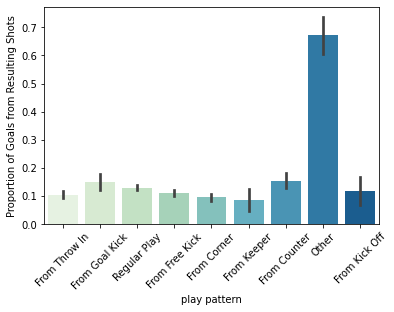

In [71]:
sns.barplot(y='binary_outcome',x='play pattern',data=train,palette='GnBu')
plt.xticks(rotation=45)
plt.ylabel('Proportion of Goals from Resulting Shots')

In [50]:
train['play pattern'].value_counts()

Regular Play      5300
From Free Kick    3028
From Throw In     2637
From Corner       2273
From Counter       704
From Goal Kick     533
Other              223
From Keeper        189
From Kick Off      162
Name: play pattern, dtype: int64

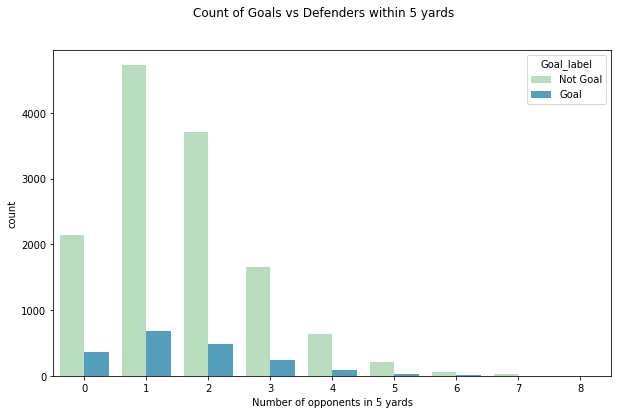

In [67]:
fig,axis = plt.subplots(1,1, figsize=(10,6))
fig.suptitle('Count of Goals vs Defenders within 5 yards')
sns.countplot(x='Number of opponents in 5 yards',data=train,hue ='Goal_label',ax=axis, palette='GnBu')

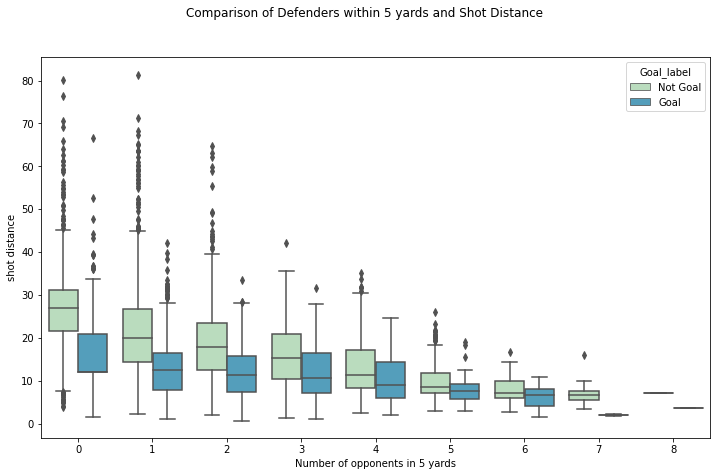

In [68]:
fig,axis = plt.subplots(1,1, figsize=(12,7))
fig.suptitle('Comparison of Defenders within 5 yards and Shot Distance')
df_none = df_regular_play[df_regular_play['Pass Type']!='None']
sns.boxplot(x='Number of opponents in 5 yards',y='shot distance',data=train,hue='Goal_label',ax=axis, palette='GnBu')

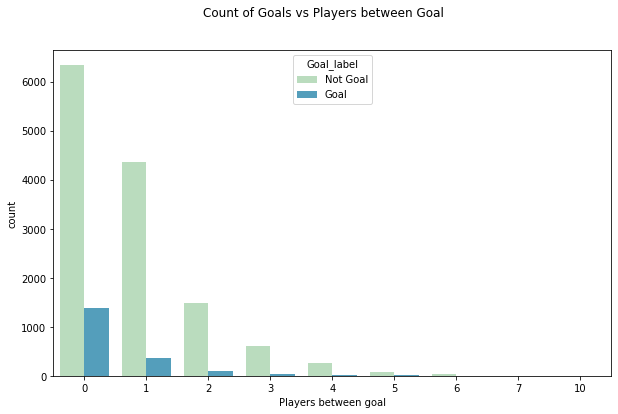

In [65]:
fig,axis = plt.subplots(1,1, figsize=(10,6))
fig.suptitle('Count of Goals vs Players between Goal')
sns.countplot(x='Players between goal',data=train,hue ='Goal_label',ax=axis,palette='GnBu')

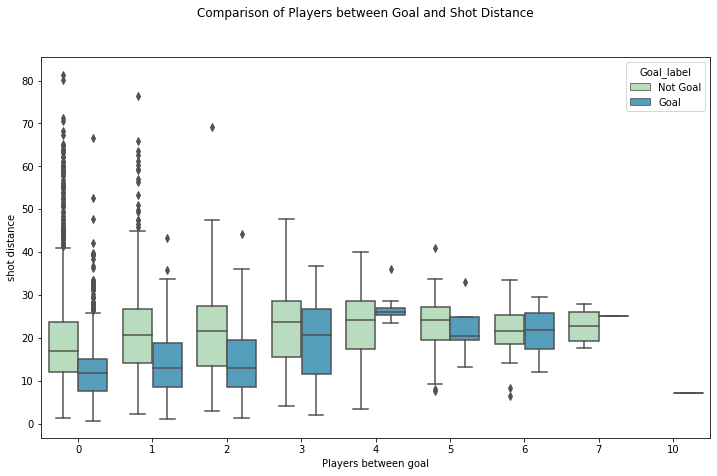

In [81]:
fig,axis = plt.subplots(1,1, figsize=(12,7))
fig.suptitle('Comparison of Players between Goal and Shot Distance')
sns.boxplot(x='Players between goal',y='shot distance',data=train,hue='Goal_label',ax=axis,palette='GnBu')

Text(0, 0.5, 'Opponents within 5 yard ')

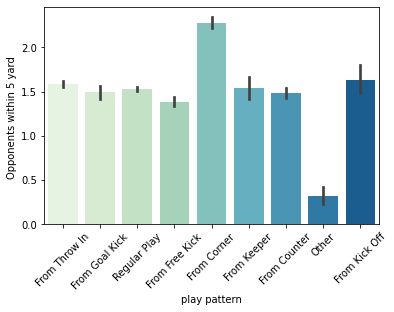

In [103]:
sns.barplot(y='Number of opponents in 5 yards',x='play pattern',data=train,palette='GnBu')
plt.xticks(rotation=45)
plt.ylabel('Opponents within 5 yard ')

Text(0, 0.5, 'Players between goal')

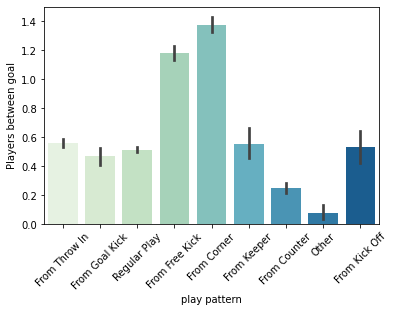

In [102]:
sns.barplot(y='Players between goal',x='play pattern',data=train,palette='GnBu')
plt.xticks(rotation=45)
plt.ylabel('Players between goal')

As we can see that the number of players between the goal and the shot taker is the least when the play type is a counter attack.

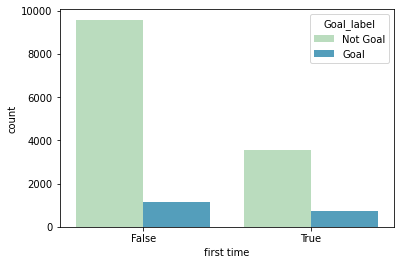

In [101]:
sns.countplot(x='first time',data=train,palette='GnBu', hue ='Goal_label')

It looks like shots taken first time result in goals on a higher rate. Let's analyze this further.

In [91]:
train.groupby('first time', as_index=False)['shot distance'].mean()

,first time,shot distance
0,False,19.703567
1,True,16.889286


Text(0, 0.5, 'Distance')

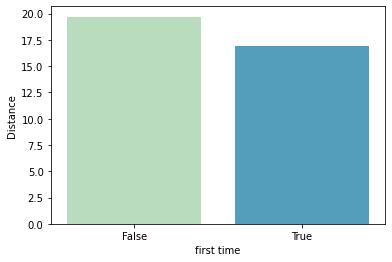

In [96]:
sns.barplot(y='shot distance',x='first time',data=train,palette='GnBu', ci=False)
plt.ylabel('Distance')

On an average, first time goals are shot from a distance of ~17 yards, while goals that are not scored are shot from ~20 yards.

Text(0, 0.5, 'Players between goal')

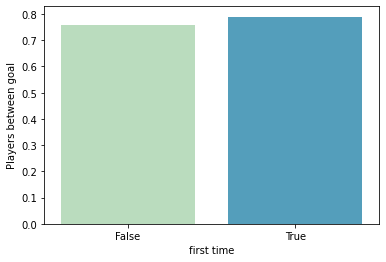

In [104]:
sns.barplot(y='Players between goal',x='first time',data=train,palette='GnBu', ci=False)
plt.ylabel('Players between goal')

Text(0, 0.5, 'Number of opponents in 5 yards')

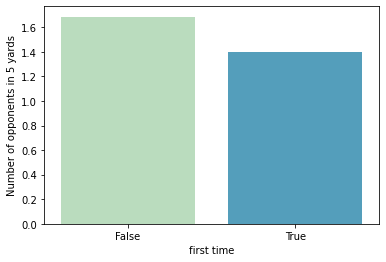

In [105]:
sns.barplot(y='Number of opponents in 5 yards',x='first time',data=train,palette='GnBu', ci=False)
plt.ylabel('Number of opponents in 5 yards')